## Test model

In [13]:
import os, cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# keras imports
import keras
from create_model import create_VGG

# allow memmory dynamic memmory allocation
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [14]:
model_name = 'best_model.h5'
result_dir = './results'

vgg_16 = create_VGG()
vgg_16.load_weights(os.path.join(result_dir, model_name))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
# directory where we are going to work on
workdir = './data'

In [16]:
# set the correct directory
ava_dir = os.path.join(workdir, 'AVA.txt')
ava_data_pd = pd.read_csv(ava_dir, sep = ' ', header = None, names = ['Index', 'Image ID', 'Rate 1', 'Rate 2',
                                                                      'Rate 3', 'Rate 4', 'Rate 5', 'Rate 6', 
                                                                      'Rate 7', 'Rate 8', 'Rate 9','Rate 10', 
                                                                      'Sem 1', 'Sem 2', 'Challenge ID'])

# separate the labels of the image IDs
x_train = ava_data_pd.values[:,1]
y_train = ava_data_pd.values[:,2:12]

In [17]:
# define directory of training images
train_dir_images = os.path.join(workdir, 'images')

# list containing the ids of the images that are not in the directory
lost_images = []

# iterate over all images
for i in range(len(x_train)):
    file_path = os.path.join(train_dir_images, str(x_train[i]) + '.jpg')
    if not os.path.exists(file_path):
        lost_images.append(i)

# mask operations
mask = np.ones((len(x_train),), bool)
mask[lost_images] = False # set to false all lost images

# prints number of lost images and original shape
print("Total images lost: ", len(lost_images))
print("Original dataset shape: ", x_train.shape)

x_train = x_train[mask]
y_train = y_train[mask]

# resulting shape
print("Resulting dataset shape: ", x_train.shape)

Total images lost:  30868
Original dataset shape:  (255530,)
Resulting dataset shape:  (224662,)


Filename:  698168.jpg


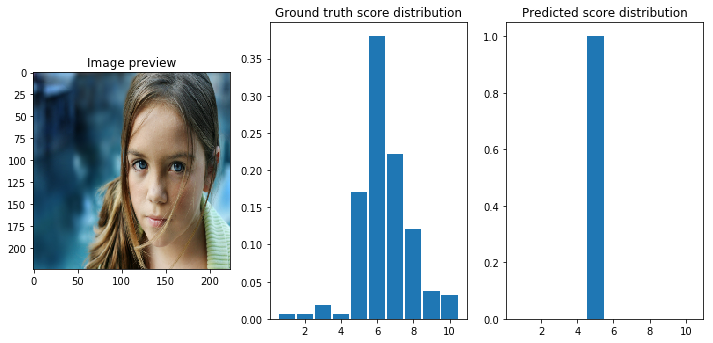

Filename:  273214.jpg


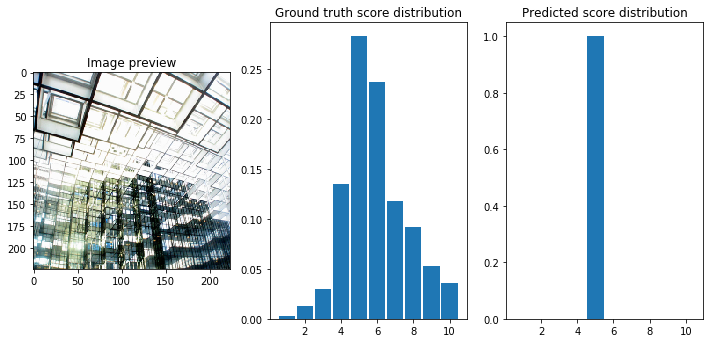

Filename:  678198.jpg


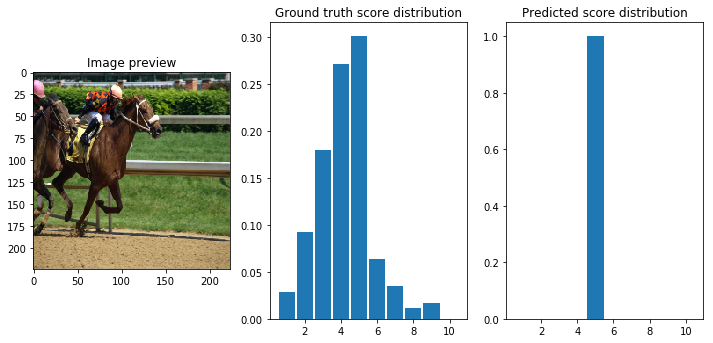

In [18]:
# number of random samples to be plotted
n_rand_samples = 3

# obtain n_rand_samples from the validation subset
val_indxs = np.random.randint(0, len(x_train), n_rand_samples)
val_images_name = x_train[val_indxs] 
val_labels_true = y_train[val_indxs]

val_images = []

# load the images into memmory
for image in val_images_name:
    case_filename = str(image) + '.jpg'
    case = os.path.join(workdir, 'images', case_filename)
    val_images.append(cv2.resize(cv2.cvtColor(cv2.imread(case, 1), cv2.COLOR_BGR2RGB), (224, 224)))

val_images = np.array(val_images)
val_labels_pred = vgg_16.predict(val_images)

# plot n_rand_samples
for i in range(n_rand_samples):

    case_filename = str(val_images_name[i]) + '.jpg'
    case = os.path.join(workdir, 'images', case_filename)
    print("Filename: ", case_filename)
    
    plt.figure(figsize=(12, 12))

    # open image with opencv and visualize it
    plt.subplot(2, 3, 1)
    image = cv2.resize(cv2.cvtColor(cv2.imread(case, 1), cv2.COLOR_BGR2RGB), (224, 224)) # cv2 loads an image BGR rather than RGB
    plt.title('Image preview')
    plt.imshow(image)
    
    # plot the ground truth score distribution of the image
    plt.subplot(2, 3, 2)
    punt_true = val_labels_true[i]
    punt_true = punt_true / np.sum(punt_true)
    plt.title('Ground truth score distribution')
    plt.bar(np.arange(1,11), height = punt_true, width = 0.9)
    
    # plot the predicted score distribution of the image
    plt.subplot(2, 3, 3)
    punt_pred = val_labels_pred[i]
    plt.title('Predicted score distribution')
    plt.bar(np.arange(1,11), height = punt_pred, width = 0.9)
    
    plt.show()